# Map 2D data

This notebook will have the algorithm for how to map 2D data using the (george package)[https://george.readthedocs.io/en/latest/]. 

>An example of doing this is present in https://gist.github.com/shoyer/80aa06f5ad44aacd9187 (using an older version of george).

The main steps are: 

First things first  
https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.



 *Using GP regression to grid ungridded data*

In [48]:
# Load appropriate modules
import george
from george import kernels
from george.kernels import Matern32Kernel

import numpy as np
import matplotlib.pyplot as plt
from itertools import product


In [8]:
# Relevant definitions 

In [9]:
# Optimisation routines

# From first example

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [10]:
# on hyperparameterisation

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True, )
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)


In [12]:
def fake_2d_data(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0] + x[:, 1]) + yerr * np.random.randn(len(x))
    return x, y





thinking about the time axis 

K&T 2018 - Sum of three Matern / Exp functions describing the covariance of the variable 
1. with reference to lat
2. with reference to lon
3. with reference to time




# following shoyer 

1 Generate 2D data (e.g. could be a 2D function like : sin (x+y) + error ),with some prescribed parameters.
  -- Alternatively, we could just use a test data set that I have for this step that has data that 
  -- is a function of (lat, lon, time), like the Argo data will be.

https://gist.github.com/shoyer/80aa06f5ad44aacd9187

## Using Matern32

Adopted by Park et al 2020  
With the advantage of the results being differentiable


In [85]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(metric=0.5, ndim=2)   #Metric is the length scale (defined in sci-kit learn) of the kernel. 
                                                    #If a float, an isotropic kernel is used.
                                                    #If an array, an anisotropic kernel is used where
                                                    #each dimension of l defines the length-scale of the
                                                    #respective feature dimension. 
# Instead of constant kernal add variance of GP?

kernel = np.var(y) * Matern32Kernel(metric=0.5, ndim=2)
                
# This test data is isotropic, but the ocean is anisotropic

#kernel = 0.5 * Matern32Kernel(metric=[[5,4],[1,5]], ndim=2)  # Example using varying length scales, this is the generarl case
#kernel = kernels.ExpSquaredKernel(metric=[13.0, 0.1],ndim=2)  # Variances in different directions (axis-aligned option)
#(tested here to see how this changes/distorts the estimated field - the optimisation function fixes this! )
# There is a third option, general case, which allows for arbitrary covariances between dimensions (e.g metric = [[12.0, 0.1],[0.1,13.0]])
# Smaller length scales result in more complex functions

print('Parameter vector',kernel.get_parameter_vector())
gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

CPU times: user 902 ms, sys: 16.4 ms, total: 918 ms
Wall time: 235 ms
Parameter vector [-1.29276715 -0.69314718]


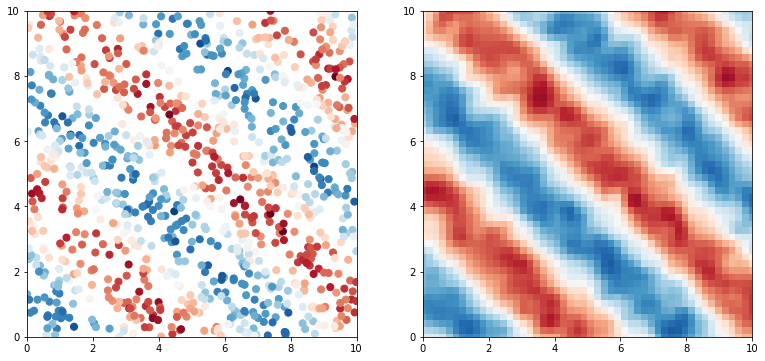

In [86]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

Optimize

In [76]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -1000.66


In [77]:

# You need to compute the GP once before starting the optimization.
gp.compute(x)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-1000.6570292478991
8.484262064866812


In [78]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -8.484262064866812
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([3.05479798e-07, 4.21673256e-07, 6.93393687e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-3.1313911 ,  0.97408999,  1.00467499])

Final ln-likelihood: 8.48


In [79]:
mu, cov = gp.predict(y, test_pts)

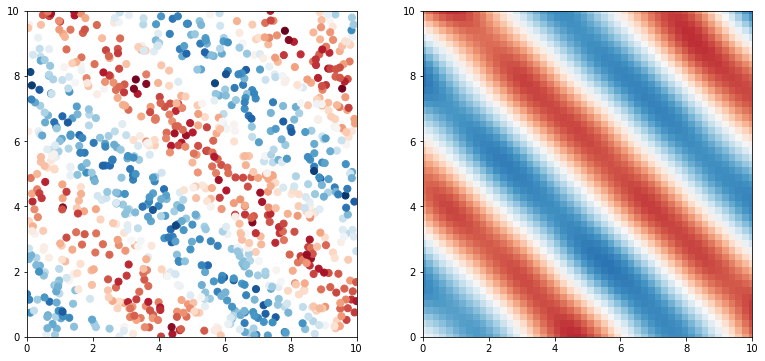

In [80]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

## Set function aligned to xaxis only

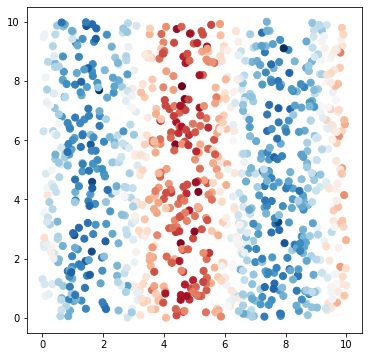

In [97]:
def fake_2d_data_vertical(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0]) + yerr * np.random.randn(len(x))
    return x, y

n_samples = 1000
x, y = fake_2d_data_vertical(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T


f, axes = plt.subplots(1, 1, figsize=(6,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)


Parameter vector [-1.44926136  0.69314718]


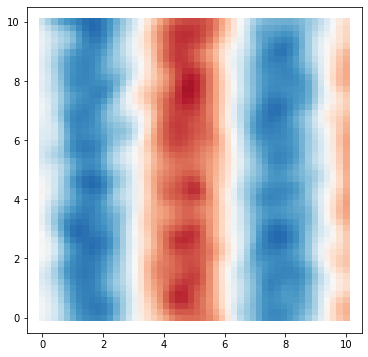

In [109]:
kernel = np.var(y) * Matern32Kernel(metric=2.0, ndim=2)  # make it isotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)



In [110]:
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))



102.71840044073616


Parameter vector [1.0593007  4.12703772]


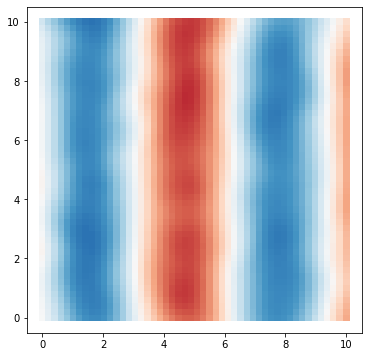

In [111]:
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


print('Parameter vector',kernel.get_parameter_vector())



Parameter vector [-1.44926136  0.69314718  2.7080502 ]
190.0113753720741
Parameter vector [-0.45815611  2.62252532 12.91212571]


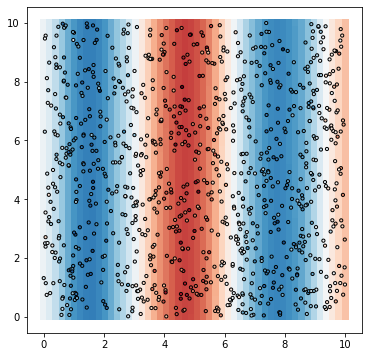

In [114]:
kernel = np.var(y) * Matern32Kernel(metric=[2.0,15], ndim=2)  # now anisotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

#, axes = plt.subplots(1, 1, figsize=(6,6))
#axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))

gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)
axes.scatter(x[:, 0], x[:, 1], c=y, s=10, **style,edgecolors='k')



print('Parameter vector',kernel.get_parameter_vector())





##  Exponential 
used by K&S 2018

In [385]:
test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T



CPU times: user 906 ms, sys: 17.6 ms, total: 924 ms
Wall time: 281 ms


In [386]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

from george import kernels
kernel = 0.5 * kernels.ExpSquaredKernel(0.5, ndim=2) 

gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

mu, cov = gp.predict(y, test_pts)

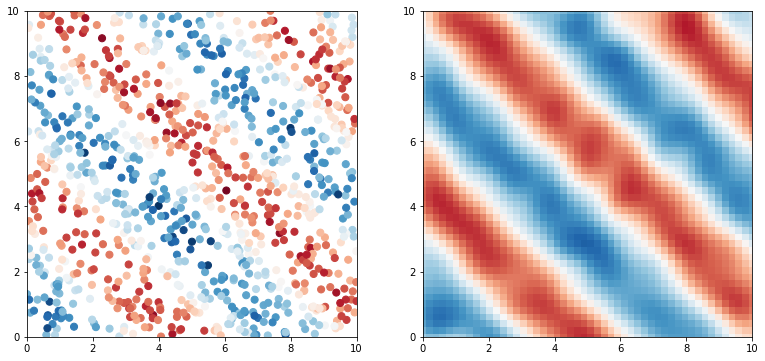

In [387]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

In [388]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -90.79


In [389]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -22.65977231802276
 hess_inv: array([[ 2.14345094e-03, -7.83241794e-05,  3.05084688e-05],
       [-7.83241794e-05,  1.78965538e-01,  5.25559211e-02],
       [ 3.05084688e-05,  5.25559211e-02,  1.91594354e-02]])
      jac: array([-1.49582204e-07, -7.91290660e-08,  5.08045872e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([-3.15705015, -0.04616422,  1.2045276 ])

Final ln-likelihood: 22.66


In [390]:
mu, cov = gp.predict(y, test_pts)

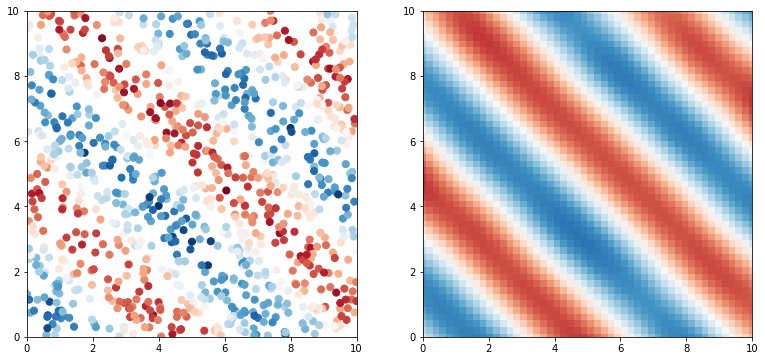

In [391]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

##  -- Decide which kernel to use for argo data



In [ ]:
#https://www.inf.ed.ac.uk/teaching/courses/mlpr/2016/notes/w7c_gaussian_process_kernels.pdf

# A Kernal is a covariance function or how related features are in space / covary with each other

# Choice linked to the distribution/ variability in region to be interpolated?

# Assume local stationarity following K&S 2018 
# Kernels that are stationary
# W&S present an anisotropic exponential space-time covariance function  - this would then allow for 3d ?

# Is it nessecary to emulate kernel from Eq 3.2 of K&S 2018 ?


## Anticipate the need to scale up

### George provides an approximate solver

In [ ]:
#Testing this out
#Compare previous to approximate solver, solutions similar, does speed things up 

In [38]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=75),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=75))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(0.5, ndim=2) 

In [39]:
gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
%time gp.compute(x)

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 39.7 ms, sys: 3.61 ms, total: 43.3 ms
Wall time: 28.9 ms
CPU times: user 3.63 s, sys: 145 ms, total: 3.77 s
Wall time: 1.24 s


In [40]:
 # quicker on the compute part 
gp_hodlr = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True,solver=george.HODLRSolver, seed=42)
%time gp_hodlr.compute(x)
print(gp_hodlr.log_likelihood(y))

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 8.71 ms, sys: 1.17 ms, total: 9.89 ms
Wall time: 9.53 ms
-501.78775542089306
CPU times: user 3.41 s, sys: 195 ms, total: 3.6 s
Wall time: 1.32 s


### Moving Window  

In [ ]:
# how did they do this? Nearest neightbours, Quadtree?  
